In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import h5py
from pathlib import Path
import os
import matplotlib.pylab as pl

from art.attacks import FastGradientMethod
from art.attacks import CarliniL2Method, CarliniLInfMethod
from art.classifiers.pytorch import PyTorchClassifier
from art.utils import load_cifar10

%matplotlib inline
%config InlineBackend.figure_format='retina'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)

train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=128)

test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=1000)

In [12]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.dropout = nn.Dropout(p=0.1)
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
def train_classifier(cl, opt, x, y):
    x.to(device)
    y.to(device)
    #Reset gradients
    opt.zero_grad()
    #Train on real data
    pred = cl(x)
    pred.to(device)
    err = F.nll_loss(F.log_softmax(pred, dim=0), y)
    #          L1 regularizer
    with torch.enable_grad():
        reg = 1e-02
        l1_loss = torch.zeros(1)
        for name, param in cl.named_parameters():
            if 'bias' not in name:  # param is a weight tensor
                l1_loss += reg*torch.sum(torch.abs(param))
    err += l1_loss.item()
    err.backward()
    #Update optimizer
    opt.step()
    return err, pred

def test_model(cl,test_loader): 
    correct = 0
    with torch.no_grad():
        cl.eval()
        for data, target in test_loader:
            output = cl(data.to(device))
            pred = output.data.max(1, keepdim=True)[1].to("cpu")
            target = np.argmax(target, axis=1)
            correct += pred.eq(target.data.view_as(pred)).sum()
        acc_test = float(correct.numpy() / len(test_loader.dataset))
        
    return acc_test

In [13]:
def make_classifier(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    # Make a classifier wrapper!
    classifier = PyTorchClassifier(
        model=model,
        clip_values=(min_, max_),
        loss=criterion,
        optimizer=optimizer,
        input_shape=(3, 32, 32),
        nb_classes=10,
    )
    return classifier



def adversarial_training(model, device, data, eps_1=0.1, eps_2=0.05):
    dim = data.size()
    batch = torch.Tensor()
    fgsm = np.random.choice([0, 1], size=dim[0], p=[.5, .5])
    for image, is_fgsm in zip(data, fgsm):
        # VIP Reshape image for model compatibility
        image = image.view(1, dim[1], dim[2], dim[3])
        image, batch = image.to(device), batch.to(device)
        classifier = make_classifier(model)
        if is_fgsm:
            adv_crafter = FastGradientMethod(classifier, eps=eps_2)
        else:
            adv_crafter = FastGradientMethod(classifier, eps=eps_1)
        perturbed_image = adv_crafter.generate(x=image.cpu().detach().numpy())
        batch = torch.cat((batch, torch.Tensor(perturbed_image).to(device)), dim=0)
    return batch

In [14]:
num_epochs = 20
e_losses = [] 

cl = Model().to(device)

# optimizer
cl_opt = optim.Adam(cl.parameters(), lr=0.001, weight_decay=0)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cl.parameters(), lr=0.01, momentum=0.5)


for e in range(num_epochs):
    cl.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        target = np.argmax(target, axis=1)  
        new_batch = adversarial_training(cl, device, data)
        c_error,c_pred = train_classifier(cl,cl_opt, new_batch.to(device), target.to(device)) 
        e_losses.append(c_error.cpu().data.numpy())
    acc = test_model(cl,test_dataloader)
    print("Epoch ", e+1, ": Test accuracy: ", 100*acc, "%")

print("Performance in the trained model: ")
acc_test = test_model(cl,test_dataloader)
print("Test accuracy: ", 100*acc_test, "%")
print("FINISHED!!!")

Epoch  1 : Test accuracy:  41.42 %
Epoch  2 : Test accuracy:  46.61 %
Epoch  3 : Test accuracy:  50.56 %
Epoch  4 : Test accuracy:  59.84 %
Epoch  5 : Test accuracy:  64.59 %
Epoch  6 : Test accuracy:  69.22 %
Epoch  7 : Test accuracy:  69.71000000000001 %
Epoch  8 : Test accuracy:  70.67999999999999 %
Epoch  9 : Test accuracy:  69.97 %
Epoch  10 : Test accuracy:  69.77 %
Epoch  11 : Test accuracy:  67.56 %
Epoch  12 : Test accuracy:  67.12 %
Epoch  13 : Test accuracy:  70.82000000000001 %
Epoch  14 : Test accuracy:  71.53 %
Epoch  15 : Test accuracy:  72.02 %
Epoch  16 : Test accuracy:  71.67999999999999 %
Epoch  17 : Test accuracy:  71.31 %
Epoch  18 : Test accuracy:  70.66 %
Epoch  19 : Test accuracy:  70.72 %
Epoch  20 : Test accuracy:  70.92 %
Performance in the trained model: 
Test accuracy:  70.92 %
FINISHED!!!


In [15]:
path = Path("C:/Users/Matach/OneDrive - Imperial College London/ICL/FYP/Experiments/saved_models/CIFAR10/FGSM Adversarial/regularization")
file = "L1_1e-02.pth"
torch.save(cl.state_dict(), os.path.join(path, file))

## Results

### L1

In [14]:
np.mean([
[0.692, 0.6764, 0.6114, 0.6886, 0.6864, 0.673, 0.6528, 0.612, 0.561],
[0.706, 0.6686, 0.6478, 0.6916, 0.691, 0.6878, 0.676, 0.6522, 0.6154]
], axis=0)

array([0.699 , 0.6725, 0.6296, 0.6901, 0.6887, 0.6804, 0.6644, 0.6321,
       0.5882])

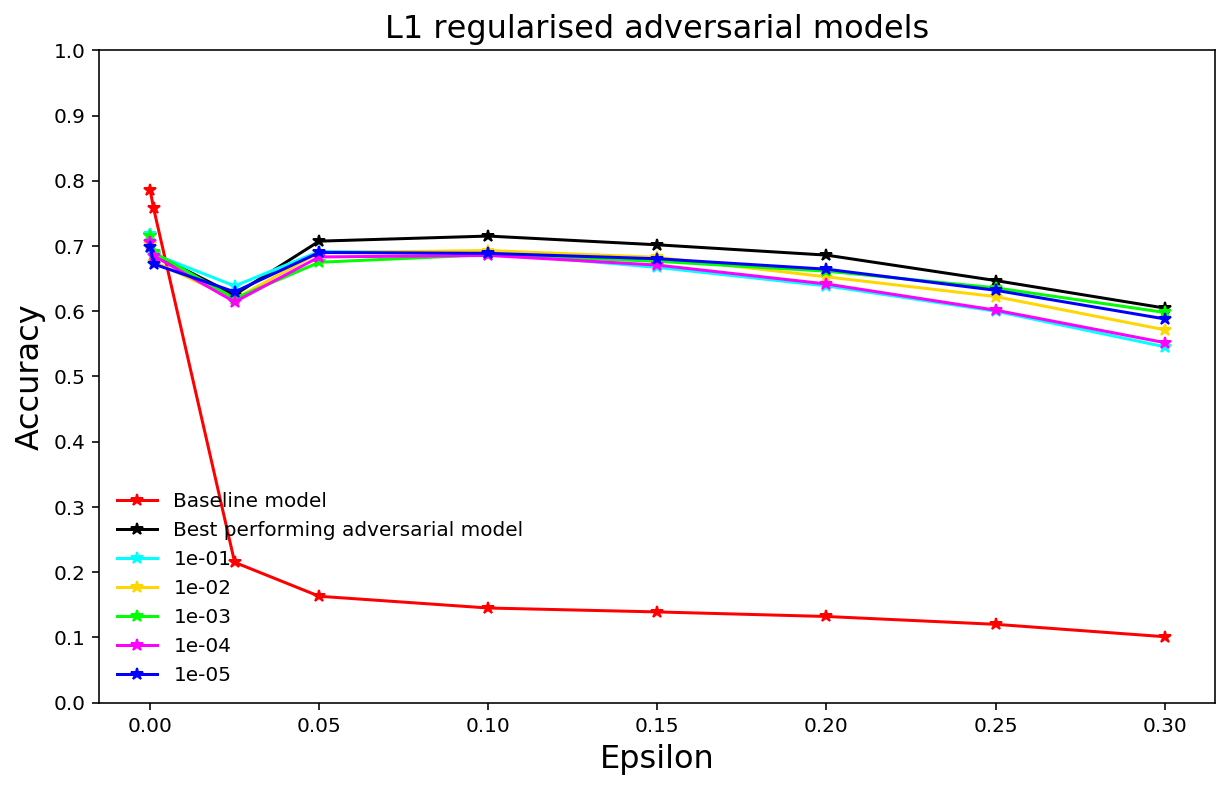

In [16]:
epsilons = [1e-06, 0.001, .025, .05, .1, .15, .2, .25, .3]
results = {
    'Baseline model': [0.786, 0.7584, 0.215, 0.163, 0.145, 0.139, 0.132, 0.12, 0.101],
    'Best performing adversarial model': [0.7162, 0.688, 0.6252, 0.7074, 0.7152, 0.7018, 0.686, 0.647, 0.6048],
    '1e-01': [0.7179, 0.6876, 0.6387, 0.6915, 0.6896, 0.6671, 0.6388, 0.6 ,0.5455],
    '1e-02': [0.7036, 0.6761, 0.6188, 0.6898, 0.693 , 0.6826, 0.6527, 0.6224, 0.5715],
    '1e-03': [0.7146, 0.6905, 0.6193, 0.675 , 0.6867, 0.6765, 0.6614, 0.6358, 0.5981],
    '1e-04': [0.7054, 0.6851, 0.6142, 0.6832, 0.6855, 0.6707, 0.6417, 0.6016, 0.5518],
    '1e-05': [0.699 , 0.6725, 0.6296, 0.6901, 0.6887, 0.6804, 0.6644, 0.6321,0.5882],

}

n = len(results)
colors = pl.cm.gnuplot(np.linspace(0,0.55,n))

colors = ['red', 'black', 'cyan', 'gold', 'lime', 'fuchsia', 'blue']

plt.figure(figsize=(10,6))

for idx, (pg, results) in enumerate(results.items()):
    plt.plot(epsilons, results, "*-", color=colors[idx], label=pg)

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("L1 regularised adversarial models",fontsize=16)
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='best', frameon=False)
plt.show()

### L2

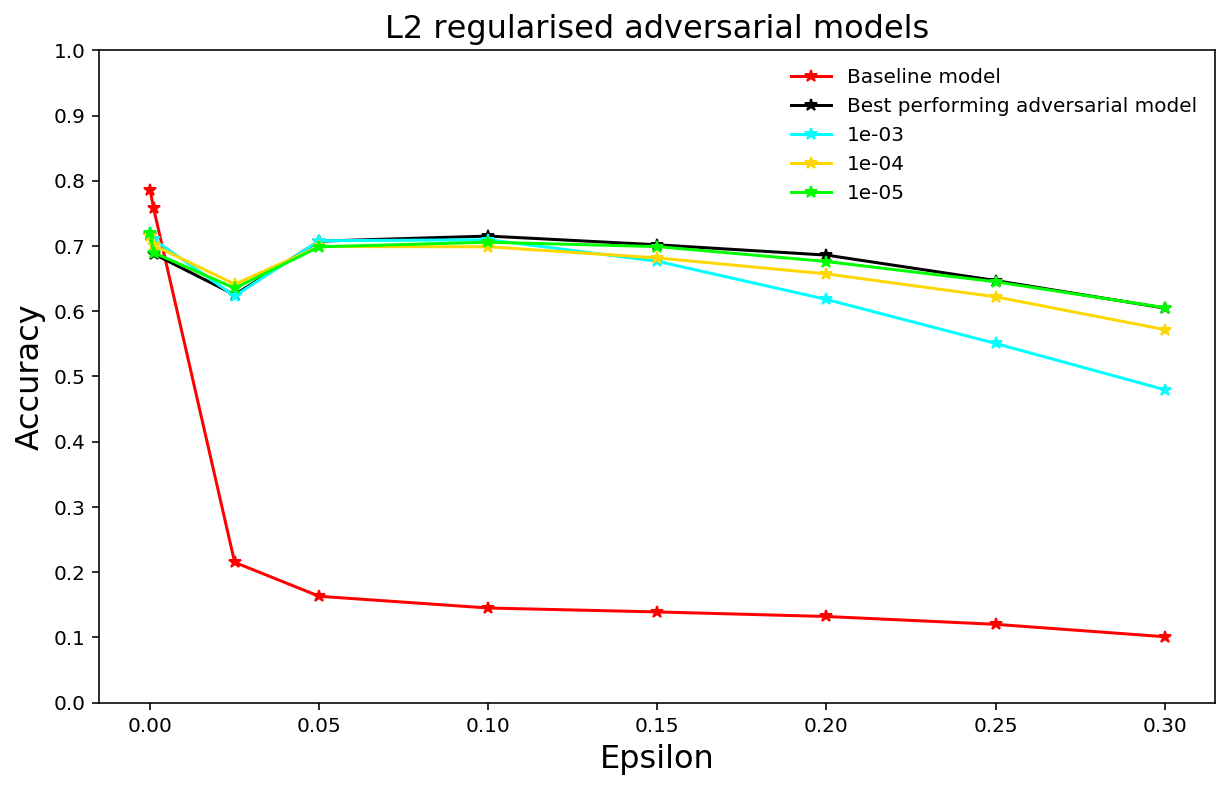

In [7]:
epsilons = [1e-06, 0.001, .025, .05, .1, .15, .2, .25, .3]
results = {
    'Baseline model': [0.786, 0.7584, 0.215, 0.163, 0.145, 0.139, 0.132, 0.12, 0.101],
    'Best performing adversarial model': [0.7162, 0.688, 0.6252, 0.7074, 0.7152, 0.7018, 0.686, 0.647, 0.6048],
    '1e-03': [0.71975, 0.7102 , 0.62325, 0.70805, 0.70955, 0.67655, 0.61805, 0.55055, 0.4797 ],
    '1e-04': [0.7151, 0.7012, 0.6415, 0.6992, 0.6987, 0.6817, 0.6572, 0.6221, 0.5718],
    '1e-05': [0.7194, 0.6898, 0.6353, 0.6987, 0.7058, 0.699 , 0.6762, 0.6451, 0.6055],
}

n = len(results)
colors = pl.cm.gnuplot(np.linspace(0,0.55,n))

colors = ['red', 'black', 'cyan', 'gold', 'lime']

plt.figure(figsize=(10,6))

for idx, (pg, results) in enumerate(results.items()):
    plt.plot(epsilons, results, "*-", color=colors[idx], label=pg)

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("L2 regularised adversarial models",fontsize=16)
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='best', frameon=False)
plt.show()